Load in Data and get example response 

In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from math import ceil
from collections import Counter
import torch


Loads in responses for the test data set

In [2]:
data_test = []
with open("data/gsm8k_inference_results.jsonl", "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if line:  # skip empty lines
            try:
                data_test.append(json.loads(line))
            except json.JSONDecodeError:
                print("Skipping invalid JSON line:", line)

Loads in predictions from GNN model

In [2]:
test_predictions = torch.load("data/test_predictions.pt", weights_only=False)
calibration_predictions = torch.load("data/calibration_predictions.pt", weights_only=False)

Loads in inference functions to use

In [3]:
from model_inference.inference_utils import *

Evaluate model and baseline on different scores for comparison

In [5]:
print(evaluate_tensor(test_predictions))
print(evaluate_baseline(data_test,method="soft_vote"))
print(evaluate_baseline(data_test,method="hard_vote"))

{'BCE': np.float32(0.38100138), 'Precision': 0.8668327265759724, 'Recall': 0.7566482689412946, 'F1': 0.8080014288265762, 'AUROC': np.float64(0.9113840033980161), 'TP': 4524, 'FP': 695, 'FN': 1455, 'Total': 13190}
{'BCE': 0.46436776216517983, 'Precision': 0.8298900366544485, 'Recall': 0.833082455260077, 'F1': 0.8314831817043653, 'AUROC': np.float64(0.9160481576424897), 'TP': 4981, 'FP': 1021, 'FN': 998, 'Total': 13190}
{'BCE': 4.897753258922861, 'Precision': 0.7568787921546494, 'Recall': 0.8971399899648771, 'F1': 0.8210622990968927, 'AUROC': np.float64(0.8290997412034897), 'TP': 5364, 'FP': 1723, 'FN': 615, 'Total': 13190}


alpha, precision, and recall tradeoff plot

C:\Users\awiel\AppData\Local\Temp\ipykernel_11976\3941753879.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(1-alpha_vals, sum(test_predictions[mask,1])/len(test_predictions[mask,1])*np.ones(len(alpha_vals)), 'b:',label="Baseline (LLM accuracy)")


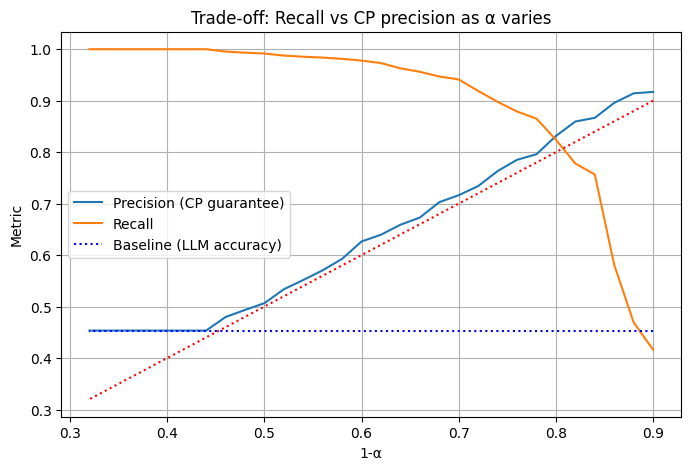

In [8]:
from matplotlib import pyplot as plt
np.random.seed(42)

recalls = []
coverages = []

alpha_vals = np.arange(0.1,0.70,0.02)
for alpha in alpha_vals:
    # Get lwoer bound based on threshold selection algorithm
    t, _ = find_cp_threshold(calibration_predictions[:,0], calibration_predictions[:,1], alpha)

    # find samples above t
    mask = test_predictions[:,0] > t
    
    # get recall and precision
    coverages.append(test_predictions[mask,1].mean() if mask.sum() > 0 else np.nan)
    recalls.append(sum(test_predictions[mask,1]>0)/sum(test_predictions[:,1] > 0))

plt.figure(figsize=(8,5))
plt.plot(1-alpha_vals, coverages, label="Precision (CP guarantee)")
plt.plot(1-alpha_vals, recalls, label="Recall")
plt.plot(1-alpha_vals, 1-alpha_vals,'r:')
plt.plot(1-alpha_vals, sum(test_predictions[mask,1])/len(test_predictions[mask,1])*np.ones(len(alpha_vals)), 'b:',label="Baseline (LLM accuracy)")
plt.xlabel("1-α")
plt.ylabel("Metric")
plt.title("Trade-off: Recall vs CP precision as α varies")
plt.legend()
plt.grid(True)
plt.show()

Biased sample for precision guarantee vs true biased precision

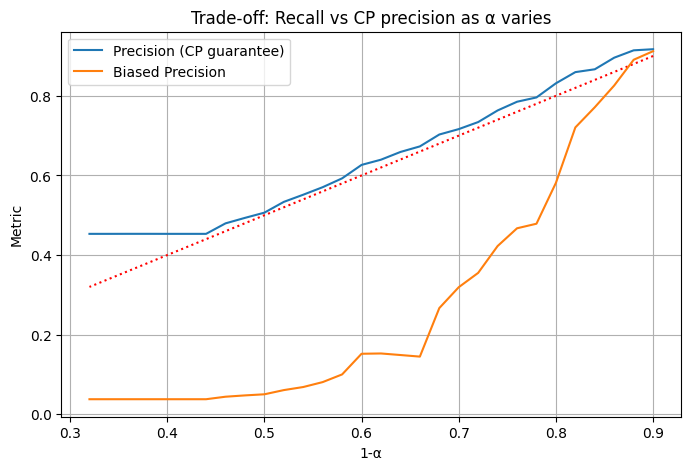

In [7]:
np.random.seed(42)

test_scores = test_predictions[:, 0]
test_labels = test_predictions[:, 1]
coverages = []
true_precision = []
alpha_vals = np.arange(0.1,0.70,0.02)

for alpha in alpha_vals:
    # get the threshold based on threshold selection algorithm
    t, _ = find_cp_threshold(calibration_predictions[:,0], calibration_predictions[:,1], alpha)

    # find samples above the threshold
    mask = test_predictions[:,0] > t

    # compute the precision of all samples above the threhsold
    coverages.append(test_predictions[mask,1].mean() if mask.sum() > 0 else np.nan)
    Bin = [t,t+0.1]
    # compute precision in the t, t+0.1 bin
    mask = (test_scores > Bin[0]) & (test_scores < Bin[1])
    true_precision.append(sum(test_labels[mask])/sum(mask))


plt.figure(figsize=(8,5))
plt.plot(1-alpha_vals, coverages, label="Precision (CP guarantee)")
plt.plot(1-alpha_vals, 1-alpha_vals,'r:')
plt.plot(1- alpha_vals,true_precision,label="Biased Precision")
plt.xlabel("1-α")
plt.ylabel("Metric")
plt.title("Trade-off: Recall vs CP precision as α varies")
plt.legend()
plt.grid(True)
plt.show()

binne lower bound precision plot

Text(0.5, 1.0, 'Binned precision: lower bounds vs truth')

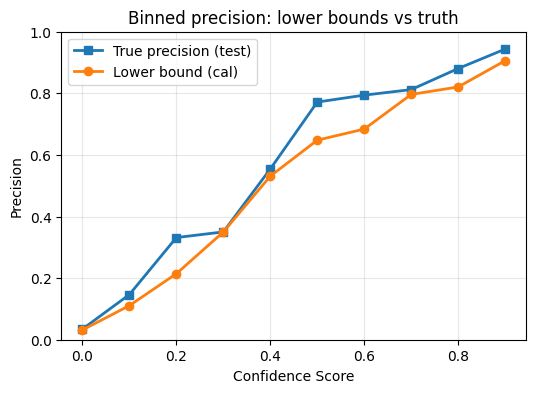

In [6]:
eps = 0.001
cal_scores = calibration_predictions[:, 0]
cal_labels = calibration_predictions[:, 1]
test_scores = test_predictions[:, 0]
test_labels = test_predictions[:, 1]

lower_bounds = []
true_precision = []
for i in range(10):
    Bin = [i*0.1,i*0.1+0.1]
    mask = (cal_scores >= Bin[0]) & (cal_scores < Bin[1])
    n = mask.sum().item() # num responses
    k=cal_labels[mask].sum().item() # num correct
    # get lower bounds
    lower_bounds.append(clopper_pearson_lower_bound(k,n,eps))

    # get true precision in the bin
    mask = (test_scores > Bin[0]) & (test_scores < Bin[1])
    true_precision.append(sum(test_labels[mask])/sum(mask))

plt.figure(figsize=(6,4))
plt.plot(np.arange(0,1,0.1), true_precision, 's-', label='True precision (test)', linewidth=2)
plt.plot(np.arange(0,1,0.1), lower_bounds, 'o-', label='Lower bound (cal)', linewidth=2)

plt.xlabel("Confidence Score")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.title("Binned precision: lower bounds vs truth")

Binned confidence interval plot

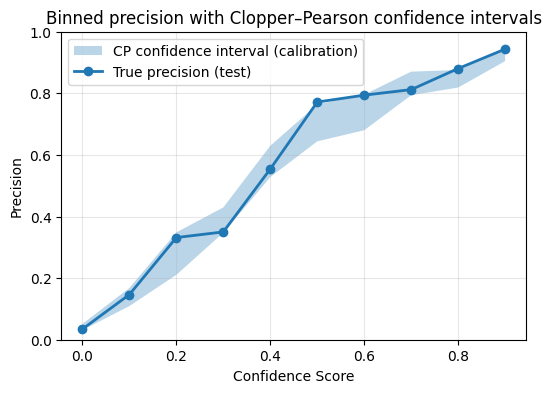

In [4]:
eps = 0.001

cal_scores = calibration_predictions[:, 0]
cal_labels = calibration_predictions[:, 1]
test_scores = test_predictions[:, 0]
test_labels = test_predictions[:, 1]

bin_left_endpoints= np.arange(0,1,0.1)
lower_bounds = []
upper_bounds = []
true_precision = []

for i in range(10):
    # define  the bin
    Bin = [i*0.1, i*0.1 + 0.1]

    # get smaples in the bin and n and k
    cal_mask = (cal_scores >= Bin[0]) & (cal_scores < Bin[1])
    n = cal_mask.sum().item()
    k = cal_labels[cal_mask].sum().item()

    # compute CI
    lb, ub = clopper_pearson_interval(k, n, eps)
    lower_bounds.append(lb)
    upper_bounds.append(ub)

    # get true precision in the bin
    test_mask = (test_scores >= Bin[0]) & (test_scores < Bin[1])
    if test_mask.sum() > 0:
        true_precision.append(test_labels[test_mask].mean())
    else:
        true_precision.append(np.nan)


plt.figure(figsize=(6,4))

plt.fill_between(bin_left_endpoints,lower_bounds,upper_bounds,alpha=0.3,label="CP confidence interval (calibration)")

plt.plot(bin_left_endpoints,true_precision,'o-',label="True precision (test)",linewidth=2)

plt.xlabel("Confidence Score")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.title("Binned precision with Clopper–Pearson confidence intervals")
plt.show()
